In [1]:
import concurrent.futures
import requests
import zipfile
import os
!pip install wget
import wget

link_train="https://zenodo.org/records/5706578/files/Train.zip?download=1"
link_val="https://zenodo.org/records/5706578/files/Val.zip?download=1"
link_test="https://zenodo.org/records/5706578/files/Test.zip?download=1"


def download_and_extract(url, destination):
  """Downloads a zip file from a URL and extracts it to a destination directory.

  Args:
    url: The URL of the zip file.
    destination: The directory to extract the zip file to.
  """

  # Download the zip file
  wget.download(url, out=destination+".zip")

  # Extract the zip file
  with zipfile.ZipFile(destination+".zip", 'r') as zip_ref:
    zip_ref.extractall(destination)

  print(f"Downloaded and extracted {url} to {destination}")

# Download and extract the train, validation, and test datasets in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(download_and_extract, link_train, 'Train'),
        executor.submit(download_and_extract, link_val, 'Val'),
        executor.submit(download_and_extract, link_test, 'Test')
    ]

    # Wait for all downloads and extractions to complete
    concurrent.futures.wait(futures)




  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d0d41f28ae5727f3bd2e028609fe304b035466e66696a4d85f1f5f9f928cbc74
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Downloaded and extracted https://zenodo.org/records/5706578/files/Val.zip?download=1 to Val
Downloaded and extracted https://zenodo.org/records/5706578/files/Test.zip?download=1 to Test
Downloaded and extracted https://zenodo.org/records/5706578/files/Train.zip?download=1 to Train


In [2]:
# 2_a) Classic semantic segmentation network.
# For this step, you have to train a classic segmentation network
# (DeepLabV2 [2]) on the LoveDA-rural dataset.
# - Dataset: LoveDA-rural [6]
# - Training epochs: 20
# - Backbone: R101 (pre-trained on ImageNet) [2]
# - Metrics: Mean Intersection over Union (mIoU) [read this to
# understand the metrics, latency, FLOPs, number of parameters
# Install necessary libraries
# segmentation-models-pytorch depends on timm, which moved the create_model function

!pip install segmentation-models-pytorch
!pip install timm
!pip install ptflops

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from collections import OrderedDict
from tqdm import tqdm
from ptflops import get_model_complexity_info
import segmentation_models_pytorch.utils


# Define paths
data_dir = "./Train"  # Replace with your actual directory structure
image_dir = os.path.join(data_dir,"Train", "Rural", "images_png")
mask_dir = os.path.join(data_dir,"Train", "Rural", "masks_png")


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=a530cb987def343d20dedecc6615c6c7602c0ca4bd6eef6ac4c1839d68e538eb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=927c70fd9324ac32351183afecf3922055f77a5b3b36c878d3960c56b53a03db
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([7, 256, 256])


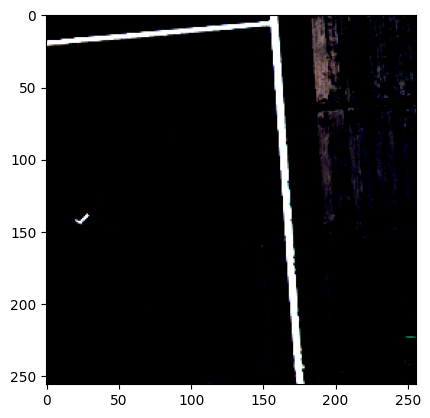

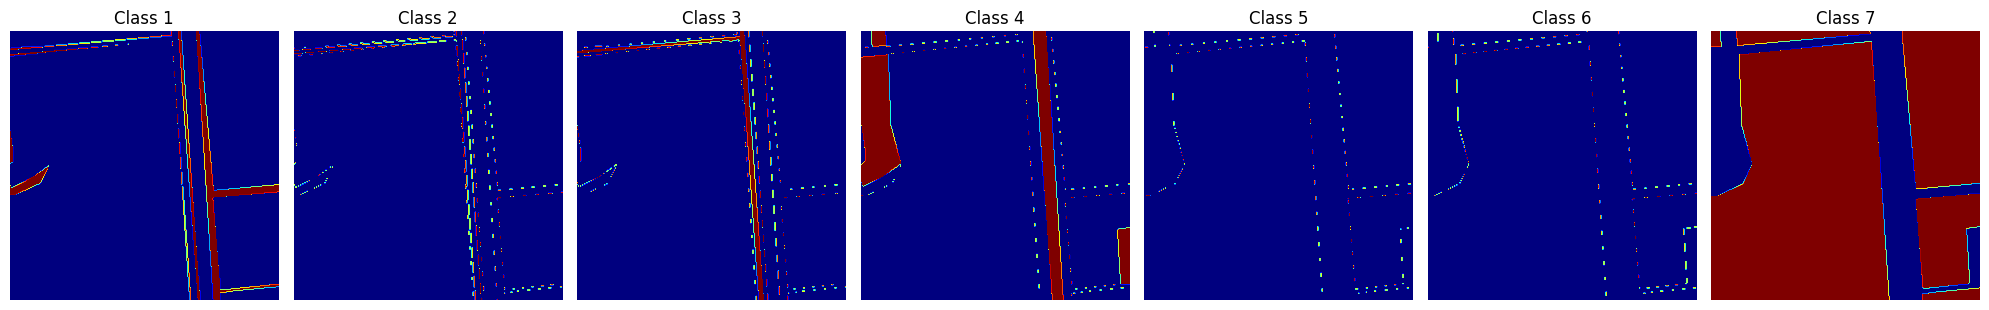

In [3]:
# Color map and label map

# Example grayscale values
COLOR_MAP = {
    'class1': 0.00392157,
    'class2': 0.00784314,
    'class3': 0.01176471,
    'class4': 0.01568628,
    'class5': 0.01960784,
    'class6': 0.02352941,
    'class7': 0.02745098
}

# Map class names to indices
LABEL_MAP = {k: v for v, k in enumerate(COLOR_MAP.keys())}

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    """
    Converts a grayscale mask to a one-hot encoded mask based on a color map and tolerance.

    Args:
        mask (np.ndarray): The input grayscale mask.
        label_map (dict): A dictionary mapping class names to label indices.
        tolerance (float): The tolerance for matching grayscale values.
        num_classes (int): Number of classes (channels).

    Returns:
        torch.Tensor: The one-hot encoded mask.
    """
    mask = np.asarray(mask, dtype=np.float32)
    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        # print(class_index, np.squeeze(matches, axis=0))
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Dataset class
class LoveDADataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

# Transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda mask: color_to_one_hot(mask, LABEL_MAP)),
])

# Dataset and DataLoaders
dataset = LoveDADataset(image_dir, mask_dir, image_transform, mask_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)

# Model definition
image, mask = dataset[13]
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")


plt.imshow(image.permute(1, 2, 0))
plt.show()

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

# Iterate through the mask channels (7 classes)
for i in range(7):
    # Extract the i-th channel
    mask_class = mask[i].cpu().numpy()  # Convert to numpy array for display

    # Display the class mask i
    axes[i].imshow(mask_class, cmap='jet')  # Use a colormap (e.g. 'jet')
    axes[i].set_title(f'Class {i + 1}')
    axes[i].axis('off')  # Disable axes

# Show result
plt.tight_layout()
plt.show()



In [8]:
import random
# Use segmentation_models_pytorch library to create DeepLabV2 with ResNet101 backbone
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 7
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=7,
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)



# Move model to device
DEVICE = torch.device("cuda")
# define loss function

loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.1),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)



train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)




TRAINING=True
EPOCHS=20

if TRAINING:

    best_iou_score = -70.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(val_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')



Epoch: 0
valid: 100%|██████████| 274/274 [00:19<00:00, 13.98it/s, dice_loss - 0.4957, iou_score - 0.326]
Model saved!

Epoch: 1
valid: 100%|██████████| 274/274 [00:19<00:00, 14.25it/s, dice_loss - 0.4635, iou_score - 0.3471]
Model saved!

Epoch: 2
valid: 100%|██████████| 274/274 [00:19<00:00, 14.35it/s, dice_loss - 0.4295, iou_score - 0.3795]
Model saved!

Epoch: 3
valid: 100%|██████████| 274/274 [00:19<00:00, 14.40it/s, dice_loss - 0.4451, iou_score - 0.4147]
Model saved!

Epoch: 4
valid: 100%|██████████| 274/274 [00:18<00:00, 14.42it/s, dice_loss - 0.41, iou_score - 0.442]
Model saved!

Epoch: 5
valid: 100%|██████████| 274/274 [00:19<00:00, 14.20it/s, dice_loss - 0.3763, iou_score - 0.4829]
Model saved!

Epoch: 6
valid: 100%|██████████| 274/274 [00:20<00:00, 13.26it/s, dice_loss - 0.4003, iou_score - 0.4591]

Epoch: 7
valid: 100%|██████████| 274/274 [00:20<00:00, 13.26it/s, dice_loss - 0.3785, iou_score - 0.4759]

Epoch: 8
valid: 100%|██████████| 274/274 [00:20<00:00, 13.39it/s, dic


Random Sample (Epoch 19)
Input Tensor:  torch.Size([1, 3, 256, 256])
Ground Truth:  torch.Size([7, 256, 256])
Model Output:  torch.Size([1, 7, 256, 256])


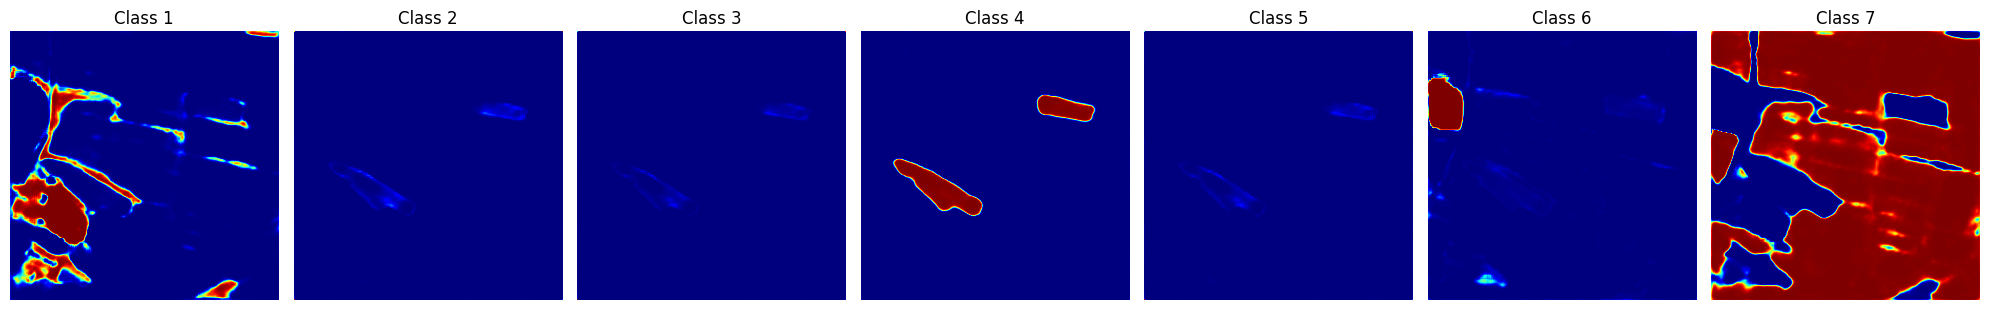

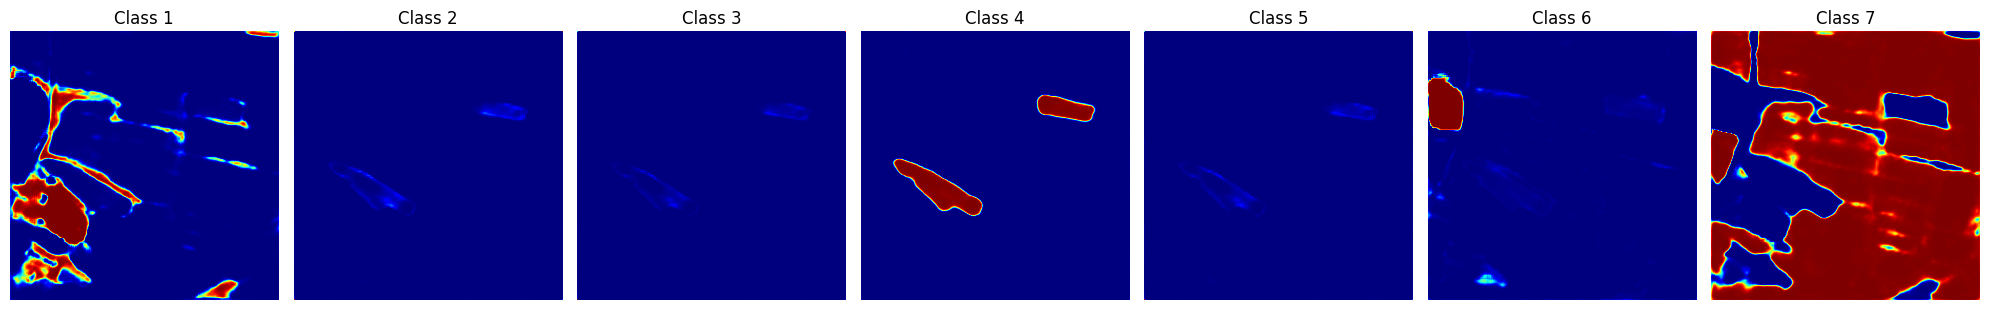

In [9]:
# Ensure the model is on the correct device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to the selected device

TRAINING=1
if TRAINING:  # Ensure you have a condition for training mode
    # Pick a random batch from the train loader
    a, b = dataset[130]
    inputs, targets = a, b  # Assuming the loader returns (input, target) pairs

    # Move the inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.unsqueeze(0)  # Add a batch dimension

    # Get the model output for the input
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():
        output = model(inputs)  # Get model prediction for the input

    # Print the random input, output, and ground truth
    print("\nRandom Sample (Epoch {})".format(i))
    print("Input Tensor: ", inputs.shape)
    print("Ground Truth: ", targets.shape)
    print("Model Output: ", output.shape)
    output = output.squeeze(0)
    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Iterate through the mask channels (7 classes)
    for i in range(7):
        # Extract the i-th channel
        mask_class = output[i].cpu().numpy()  # Convert to numpy array for display

        # Display the class mask i
        axes[i].imshow(mask_class, cmap='jet') # Use a colormap (e.g. 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disable axes


    # Show result
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Iterate through the mask channels (7 classes)
    for i in range(7):
        # Extract the i-th channel
        mask_class = output[i].cpu().numpy()  # Convert to numpy array for display

        # Display the class mask i
        axes[i].imshow(mask_class, cmap='jet') # Use a colormap (e.g. 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disable axes

    # Show result
    plt.tight_layout()
    plt.show()

    model.train()

In [10]:
!pip install fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=24364605905c5166509dfd824e75d50d5325c2456b8ec7e8d355250f9c200e1d
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=734ad97b74c81b7601dae71941f95c76d00fecd519cf304809f92aeecb70cba7
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [17]:
#deeplabv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import os
from PIL import Image

import time
from fvcore.nn import FlopCountAnalysis, parameter_count_table  # Ensure you install fvcore

# --- Model Definition ---
class DeepLabV2(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV2, self).__init__()
        # Load the pre-trained ResNet-101 backbone
        resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)

        # Remove the fully connected layer of ResNet-101
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # ASPP (Atrous Spatial Pyramid Pooling) module
        self.aspp = nn.Sequential(
            ASPP(2048, [6, 12, 18, 24], 256),  # Output channels are 256
            nn.Conv2d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.aspp(x)
        x = F.interpolate(x, scale_factor=32, mode='bilinear', align_corners=True)
        return x

class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        for rate in atrous_rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


# --- Training (Optional) ---
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in tqdm(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        miou = evaluate(model, val_loader, device, NUM_CLASSES)
        print(f'mIoU: {miou:.4f}')

# --- Evaluation (mIoU) ---
def calculate_iou(pred_mask, true_mask, num_classes):
    iou_per_class = []
    for cls in range(num_classes):
        true_cls = true_mask == cls
        pred_cls = pred_mask == cls
        intersection = torch.logical_and(true_cls, pred_cls).sum().float()
        union = torch.logical_or(true_cls, pred_cls).sum().float()
        iou = (intersection + 1e-8) / (union + 1e-8)  # Add epsilon to avoid division by zero
        iou_per_class.append(iou.item())
    return iou_per_class

def evaluate(model, data_loader, device, num_classes):
    model.eval()
    total_iou = []
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            iou = calculate_iou(preds, masks, num_classes)
            total_iou.extend(iou)

    avg_iou = np.mean(total_iou)
    return avg_iou


# --- Main ---
if __name__ == "__main__":
    # Hyperparameters
    NUM_CLASSES = 7  # Example: Pascal VOC has 21 classes (including background)
    BATCH_SIZE = 1
    LEARNING_RATE = 0.00009
    NUM_EPOCHS = 20 # 10

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model
    model = DeepLabV2(num_classes=NUM_CLASSES).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training (optional)
    train(model, train_loader, criterion, optimizer, device, num_epochs=NUM_EPOCHS)

    # Evaluation
    miou = evaluate(model, val_loader, device, NUM_CLASSES)
    print(f'mIoU: {miou:.4f}')

    # Save the model (optional)
    torch.save(model.state_dict(), 'deeplabv2_resnet101.pth')


100%|██████████| 1092/1092 [01:53<00:00,  9.58it/s]


Epoch 1/20, Loss: 1.3771


100%|██████████| 274/274 [00:21<00:00, 12.62it/s]


mIoU: 0.3954


100%|██████████| 1092/1092 [01:46<00:00, 10.21it/s]


Epoch 2/20, Loss: 1.2651


100%|██████████| 274/274 [00:19<00:00, 14.09it/s]


mIoU: 0.3668


100%|██████████| 1092/1092 [01:51<00:00,  9.78it/s]


Epoch 3/20, Loss: 0.9449


100%|██████████| 274/274 [00:20<00:00, 13.63it/s]


mIoU: 0.4069


100%|██████████| 1092/1092 [01:51<00:00,  9.79it/s]


Epoch 4/20, Loss: 0.8693


100%|██████████| 274/274 [00:20<00:00, 13.53it/s]


mIoU: 0.2915


100%|██████████| 1092/1092 [01:53<00:00,  9.64it/s]


Epoch 5/20, Loss: 0.8386


100%|██████████| 274/274 [00:20<00:00, 13.43it/s]


mIoU: 0.3206


100%|██████████| 1092/1092 [01:53<00:00,  9.59it/s]


Epoch 6/20, Loss: 0.7800


100%|██████████| 274/274 [00:19<00:00, 13.97it/s]


mIoU: 0.3205


100%|██████████| 1092/1092 [01:50<00:00,  9.91it/s]


Epoch 7/20, Loss: 0.7515


100%|██████████| 274/274 [00:19<00:00, 13.91it/s]


mIoU: 0.3291


100%|██████████| 1092/1092 [01:47<00:00, 10.11it/s]


Epoch 8/20, Loss: 0.6991


100%|██████████| 274/274 [00:21<00:00, 12.65it/s]


mIoU: 0.3177


100%|██████████| 1092/1092 [01:47<00:00, 10.17it/s]


Epoch 9/20, Loss: 0.6538


100%|██████████| 274/274 [00:20<00:00, 13.46it/s]


mIoU: 0.3410


100%|██████████| 1092/1092 [01:47<00:00, 10.13it/s]


Epoch 10/20, Loss: 0.6386


100%|██████████| 274/274 [00:19<00:00, 14.21it/s]


mIoU: 0.3173


100%|██████████| 1092/1092 [01:51<00:00,  9.80it/s]


Epoch 11/20, Loss: 0.5917


100%|██████████| 274/274 [00:19<00:00, 13.86it/s]


mIoU: 0.3092


100%|██████████| 1092/1092 [01:51<00:00,  9.80it/s]


Epoch 12/20, Loss: 0.5288


100%|██████████| 274/274 [00:19<00:00, 13.73it/s]


mIoU: 0.3031


100%|██████████| 1092/1092 [01:51<00:00,  9.79it/s]


Epoch 13/20, Loss: 0.5018


100%|██████████| 274/274 [00:19<00:00, 13.92it/s]


mIoU: 0.2616


100%|██████████| 1092/1092 [01:51<00:00,  9.84it/s]


Epoch 14/20, Loss: 0.5643


100%|██████████| 274/274 [00:19<00:00, 13.99it/s]


mIoU: 0.2987


100%|██████████| 1092/1092 [01:48<00:00, 10.11it/s]


Epoch 15/20, Loss: 0.4927


100%|██████████| 274/274 [00:20<00:00, 13.68it/s]


mIoU: 0.2524


100%|██████████| 1092/1092 [01:50<00:00,  9.90it/s]


Epoch 16/20, Loss: 0.4470


100%|██████████| 274/274 [00:19<00:00, 13.78it/s]


mIoU: 0.2698


100%|██████████| 1092/1092 [01:49<00:00,  9.99it/s]


Epoch 17/20, Loss: 0.4408


100%|██████████| 274/274 [00:21<00:00, 12.71it/s]


mIoU: 0.2816


100%|██████████| 1092/1092 [01:47<00:00, 10.15it/s]


Epoch 18/20, Loss: 0.5086


100%|██████████| 274/274 [00:20<00:00, 13.69it/s]


mIoU: 0.2541


100%|██████████| 1092/1092 [01:49<00:00,  9.96it/s]


Epoch 19/20, Loss: 0.4214


100%|██████████| 274/274 [00:19<00:00, 13.95it/s]


mIoU: 0.2880


100%|██████████| 1092/1092 [01:49<00:00,  9.95it/s]


Epoch 20/20, Loss: 0.4091


100%|██████████| 274/274 [00:19<00:00, 14.03it/s]


mIoU: 0.2761


100%|██████████| 274/274 [00:19<00:00, 13.82it/s]


mIoU: 0.2761


In [14]:
!pip install torch torchvision thop opencv-python tqdm numpy scipy #manually install the necessary libraries:

In [18]:
import time
from thop import profile, clever_format #used at the end
# Performance Evaluation (Latency, FLOPs, and Parameters)
print("\nEvaluating Model Performance:")

# Measure latency
dummy_input = torch.randn(1, 3, 512, 512).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    model(dummy_input)
    end_time = time.time()
latency = (end_time - start_time) * 1000  # Convert to milliseconds
print(f"Latency: {latency:.2f} ms")

# Compute FLOPs and Params
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"FLOPs: {flops}")
print(f"Params: {params}")




Evaluating Model Performance:
Latency: 15.00 ms
FLOPs: 46.139G
Params: 62.231M
